In [1]:
import os,sys,signal, copy
import math
from contextlib import contextmanager

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
import matplotlib.ticker as ticker
from matplotlib.animation import ArtistAnimation

from scipy.fftpack import fft
from scipy.signal.windows import hann

sys.path.insert(0, '../../')
import musicnetRaven as musicnet

from time import time

sys.path.insert(0,'../../lib/')
import config
import diagnosticsP3
# import base_model

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn
from torchcontrib.optim import SWA

from tqdm import tqdm
import mir_eval

from torchsummary import summary

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Network Parameters
epochs = 20
train_size = 100000
test_size = 50000
lr = 5e-4
pitch_shift = 0
jitter = 0.
num_workers = 15

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

In [3]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [4]:
regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [5]:
start = time()
root = '../../../data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True, refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Time used = ", time()-start)

Time used =  27.594401121139526


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [7]:
def create_filtersv2(n_fft, freq_bins=None, low=50,high=6000, sr=44100, freq_scale='linear', mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    

    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        
    if freq_scale == 'linear':
        start_bin = start_freq*n_fft/sr
        scaling_ind = (end_freq/start_freq)/freq_bins
        for k in range(freq_bins): # Only half of the bins contain useful info
            wsin[k,0,:] = window_mask*torch.sin(2*math.pi*(k*scaling_ind*start_bin)*s/n_fft)
            wcos[k,0,:] = window_mask*torch.cos(2*math.pi*(k*scaling_ind*start_bin)*s/n_fft)
    elif freq_scale == 'log':
        start_bin = start_freq*n_fft/sr
        scaling_ind = np.log(end_freq/start_freq)/freq_bins
        for k in range(freq_bins): # Only half of the bins contain useful info
            wsin[k,0,:] = window_mask*torch.sin(2*math.pi*(np.exp(k*scaling_ind)*start_bin)*s/n_fft)
            wcos[k,0,:] = window_mask*torch.cos(2*math.pi*(np.exp(k*scaling_ind)*start_bin)*s/n_fft)    
    else:
        print("Please select the correct frequency scale, 'linear' or 'log'")
    
    return wsin,wcos


In [8]:
Loss = nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [9]:
class Model(nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        # Create filter windows
        wsin, wcos = create_filtersv2(n_fft,k, low=50, high=6000,
                                      mode="stft", freq_scale='log')
        with torch.cuda.device(0):
            self.wsin = torch.Tensor(wsin).cuda()
            self.wcos = torch.Tensor(wcos).cuda()
            
        # Creating Layers
#         self.linear = torch.nn.Linear(regions*k, k,bias=False)
#         self.linear_output = torch.nn.Linear(k,m, bias=False)
#         wscale = 10e-5
#         torch.nn.init.normal_(self.linear.weight, std=1e-4) # initialize
#         torch.nn.init.normal_(self.linear_output.weight, std=1e-4)
#         torch.nn.init.zeros_(self.linear.weight)
#         torch.nn.init.zeros_(self.linear_output.weight)
        k_out = 128
        k2_out = 256
        stride1 = (2,1)
        self.CNN_freq = nn.Conv2d(1,k_out,
                                kernel_size=(128,1),stride=(2,1))
        self.CNN_time = nn.Conv2d(k_out,k2_out,
                                kernel_size=(1,25),stride=(1,1))
        self.Linear = nn.Linear(k2_out*1*193, m)
        self.activation = nn.ReLU()
        
        torch.nn.init.normal_(self.CNN_freq.weight, std=1e-4)
        torch.nn.init.normal_(self.CNN_time.weight, std=1e-4)
        torch.nn.init.normal_(self.Linear.weight, std=1e-4)
        
        
        self.avg = avg
        #Create a container for weight average
        self.averages = copy.deepcopy(list(parm.cuda().data for parm in self.parameters())) 
    def _get_conv_output(self, shape):
        bs = 1
        x = torch.tensor(torch.rand(bs, *shape))
        output_feat = self._forward_features(x)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size
        
    def forward(self,x):
        zx = conv1d(x[:,None,:], self.wsin, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos, stride=stride).pow(2)
        zx = torch.log(zx + 10e-8) # Log Magnitude Spectrogram
        z2 = self.CNN_freq(zx.unsqueeze(1)) # Make channel as 1 (N,C,H,W)
        z2 = F.relu(z2)
        z3 = self.CNN_time(z2)
        z3 = F.relu(z3)
        y = self.Linear(self.activation(torch.flatten(z3,1)))
        return y
    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data) # 0.9W_avg + 0.1W_this_ite
    
    
@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Averaged Weights

In [10]:
model = Model()
model.cuda()

result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter

In [11]:
avg = .9998
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        total_i = len(train_loader)
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.FloatTensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"Training {i}/{total_i} batches", end = '\r')
                optimizer.zero_grad()
#                 print(model.Layer2.weight[0][0][0])
                # making x and y into pytorch dealable format
                x = x.cuda(non_blocking=True)
                y = y.cuda(non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number
                
                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
                
                optimizer.step()
                model.average_iterates() # Averaging the weights for validation
                
            avgp = average_precision_score(yground.flatten(),yhat.flatten())    
            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight
            
            # For testing
            yground = torch.FloatTensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            
            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"Testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.cuda()
                y_test = y_test.cuda()
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))


        
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")
    

epoch	train loss	test loss	train avg	test avg	time	utime
0	0.872840	0.579870	0.609164	0.696836	88.8	8.8
1	0.720267	0.554404	0.707904	0.720650	88.1	8.9
2	0.691735	0.536529	0.725534	0.724427	88.0	8.9
3	0.674630	0.531339	0.737422	0.731115	87.9	8.9
4	0.664384	0.521131	0.744958	0.740008	87.9	8.9
5	0.655542	0.527246	0.751637	0.735814	87.9	9.0
6	0.645219	0.521146	0.757003	0.744558	87.7	8.9
7	0.639508	0.519127	0.762822	0.743237	88.3	9.2
8	0.634566	0.518729	0.764806	0.744968	89.0	9.3
9	0.631233	0.514848	0.767802	0.745257	88.9	9.3
10	0.627143	0.516804	0.769427	0.743852	88.9	9.4
11	0.622637	0.510320	0.774208	0.748962	89.5	9.3
12	0.620055	0.518266	0.776871	0.750005	88.6	9.2
13	0.616088	0.515958	0.778629	0.754783	88.4	9.2
14	0.615609	0.523200	0.780358	0.750511	89.5	9.6
15	0.613733	0.520093	0.781060	0.750993	90.4	9.3
16	0.610254	0.521445	0.784117	0.753428	88.7	9.3
17	0.608628	0.523822	0.783586	0.748692	89.8	9.3
18	0.608830	0.507685	0.783674	0.751525	88.5	9.3
19	0.604546	0.514421	0.787130	0.746110	88

(0.3, 0.8)

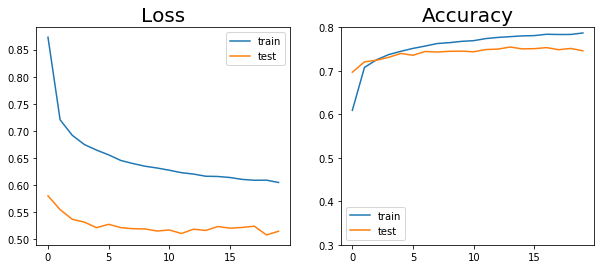

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(result_dict['loss_history_train'])
ax[0].plot(result_dict['loss_history_test'])
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(result_dict['avgp_history_train'])
ax[1].plot(result_dict['avgp_history_test'])
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)
ax[1].set_ylim(0.3,0.80)

In [17]:
torch.save(model.state_dict(), './weights/2 Layers CNN-Tried Another Optim')
with open('./weights/2 Layers CNN-Tried Another Optim.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

In [19]:
from numba import cuda
cuda.select_device(0)
cuda.close()

# Mirex stats

In [18]:
def get_mir_accuracy(Yhat, Y_true, threshold=0.4):
    Yhatlist = []
    Ylist = []
    Yhatpred = Yhat>threshold
    for i in range(len(Yhatpred)):
        print(f"{i}/{len(Yhatpred)} batches", end = '\r')
        fhat = []
        f = []
        for note in range(m):
            if Yhatpred[i][note] == 1:
                fhat.append(440.*2**(((note)-69.)/12.))

            if Y_true[i][note] == 1:
                f.append(440.*2**(((note)-69.)/12.))

        Yhatlist.append(np.array(fhat))
        Ylist.append(np.array(f))
    avp = average_precision_score(Y_true.flatten(),Yhat.detach().cpu().flatten())
    P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
    mir_eval.multipitch.metrics(np.arange(len(Ylist))/100.,Ylist,np.arange(len(Yhatlist))/100.,Yhatlist)
    print('{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(100*avp,100*P,100*R,Acc,Etot,Esub,Emiss,Efa))
    return avp,P,R,Acc,Etot
def get_piano_roll(rec_id, window=16384, stride=1000, offset=44100, count=7500):
    sf=4
    if stride == -1:
        stride = (test_set.records[rec_id][1] - offset - int(sf*window))/(count-1)
        stride = int(stride)
    else:
        count = (test_set.records[rec_id][1] - offset - int(sf*window))/stride + 1
        count = int(count)
        
    X = np.zeros([count, window])
    Y = np.zeros([count, m])    
        
    for i in range(count):
        X[i,:], Y[i] =  test_set.access(rec_id, offset+i*stride)
        
    batch_size = 500
    Y_pred = torch.zeros([count,m])
    for i in range(len(X)//500):
        X_batch = torch.tensor(X[batch_size*i:batch_size*(i+1)]).float().cuda()   
        print(X_batch.shape)
        Y_pred[batch_size*i:batch_size*(i+1)] = model(X_batch)
    
    return Y_pred, Y
    

In [19]:
rec_id = 2556
offset=44100
sf=4
if stride == -1:
    stride = (test_set.records[rec_id][1] - offset - int(sf*window))/(count-1)
    stride = int(stride)
else:
    count = (test_set.records[rec_id][1] - offset - int(sf*window))/stride + 1
    count = int(count)

X = np.zeros([count, window])
Y = np.zeros([count, m])    

for i in range(count):
    X[i,:], Y[i] =  test_set.access(rec_id, offset+i*stride)

In [20]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
for songid in test_set.rec_ids:
    Y_pred, Y_true = get_piano_roll(songid, stride=-1)
#     Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = get_mir_accuracy(Y_pred, Y_true)
    Accavg += Acc
    Etotavg += Etot

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
torch.Size([500, 16384])
torch.Size([500, 16384])
torch.Size([500, 16384])
torch.Size([500, 16384])
torch.Size([500, 16384])
torch.Size([500, 16384])
torch.Size([500, 16384])
torch.Size([500, 16384])
torch.Size([500, 16384])
torch.Size([500, 16384])


RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 31.74 GiB total capacity; 26.72 GiB already allocated; 63.81 MiB free; 246.40 MiB cached)

In [ ]:
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'.format(Accavg*100/len(test_set.rec_ids), Etotavg*100/len(test_set.rec_ids)))

In [44]:
for songid in [1759]:
    model.eval()
    Y_pred, Y_true = get_piano_roll(songid, stride=-1)
#     Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = get_mir_accuracy(Y_pred, Y_true)

torch.Size([16384])


IndexError: too many indices for tensor of dimension 1

In [30]:
from pypianoroll import Multitrack, Track, load, parse

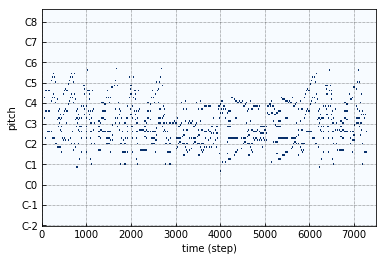

In [83]:
# Create a piano-roll matrix, where the first and second axes represent time
# and pitch, respectively, and assign a C major chord to the piano-roll
# Create a `pypianoroll.Track` instance
track = Track(pianoroll=Y_true*127, program=0, is_drum=False,
              name='my awesome piano')

# Plot the piano-roll
fig, ax = track.plot()

In [87]:
Yhatpred = Y_pred > 0.4

In [88]:
Yhatpred = Yhatpred.cpu().numpy()

In [93]:
def export_midi(Y_pred, path):
    # Create a piano-roll matrix, where the first and second axes represent time
    # and pitch, respectively, and assign a C major chord to the piano-roll
    # Create a `pypianoroll.Track` instance
    track = Track(pianoroll=Y_pred*127, program=0, is_drum=False,
                  name='my awesome piano')   
    multitrack = Multitrack(tracks=[track], tempo=120.0, beat_resolution=24)
    multitrack.write(path)

In [96]:
export_midi(Y_true, './Y_true.mid')

In [102]:
torch.save(model, './weights/Toy_model_full')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
